# SHAP Explainability Analysis for Hybrid Fusion Model

## Key Objectives

**Explainability Strategy:**
- Load existing trained meta-learner (no retraining needed)
- Load test data with renamed features from `final_processed_data/`
- Map renamed features back to original order for model compatibility
- Display SHAP results with interpretable feature names

**What we'll analyze:**
1. **Global Feature Importance** - Which features matter most across all predictions
2. **Local Explanations** - Why specific fraud cases were flagged  
3. **Feature Interactions** - How features work together
4. **Model Transparency** - Make the "black box" interpretable

This analysis enables **regulatory compliance** and builds **trust** in automated fraud detection decisions.

# SHAP Explainability Analysis
## Hybrid Fusion Model - Feature Importance & Prediction Explanation

**Objective:** Explain the hybrid fusion model's predictions using SHAP (SHapley Additive exPlanations)

**Key Analyses:**
1. Global feature importance (top 20 features)
2. SHAP summary plots and dependence plots
3. Individual prediction explanations (waterfall plots)
4. Feature contribution analysis

**Model:** `meta_learner_features_api.pkl` (102 features: 92 raw + 10 predictions)

---

## Step 1: Import Required Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# SHAP library
import shap

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Ensure output directory exists
output_dir = Path('../../Results/explainability')
output_dir.mkdir(parents=True, exist_ok=True)

print("="*80)
print("SHAP EXPLAINABILITY ANALYSIS - HYBRID FUSION MODEL")
print("="*80)
print(f"✓ All libraries imported successfully")
print(f"✓ Output directory: {output_dir}")
print(f"✓ SHAP version: {shap.__version__}")

SHAP EXPLAINABILITY ANALYSIS - HYBRID FUSION MODEL
✓ All libraries imported successfully
✓ Output directory: ..\..\Results\explainability
✓ SHAP version: 0.47.2


## Step 2: Load Model and Data

In [12]:
print("Loading Model and Data...")
print("-"*80)

# Load the feature-based meta-learner (API deployment model)
meta_learner = joblib.load('meta_learner_features_api.pkl')
print("✓ Loaded: meta_learner_features_api.pkl")

# Load model info
with open('meta_learner_info.json', 'r') as f:
    model_info = json.load(f)

feature_names = model_info['features_api']['feature_names']
print(f"✓ Model uses {len(feature_names)} features")

# Load test data
X_test_features = np.load('p_features_test.npy')
y_test = np.load('predictions/y_test.npy')

# Convert to DataFrame with feature names
X_test_df = pd.DataFrame(X_test_features, columns=feature_names)

print(f"✓ Test samples loaded: {X_test_df.shape[0]:,}")
print(f"✓ Features: {X_test_df.shape[1]}")
print(f"\nModel Performance:")
print(f"  Test F1-Score: {model_info['features_api']['test_f1']:.4f}")
print(f"  Test ROC-AUC: {model_info['features_api']['test_roc_auc']:.4f}")
print(f"  Optimal Threshold: {model_info['features_api']['threshold']:.2f}")

Loading Model and Data...
--------------------------------------------------------------------------------
✓ Loaded: meta_learner_features_api.pkl
✓ Model uses 102 features
✓ Test samples loaded: 12,064
✓ Features: 102

Model Performance:
  Test F1-Score: 0.6186
  Test ROC-AUC: 0.8633
  Optimal Threshold: 0.80


In [13]:
print("Loading Renamed Test Data from Complete Pipeline...")
print("-"*80)

# Load the complete renamed dataset
data_path = '../../data/final_processed_data/'

# Load test data with renamed features
X_test_renamed = pd.read_csv(f'{data_path}X_test_scaled.csv')
y_test_new = pd.read_csv(f'{data_path}y_test.csv').values.ravel()

print(f"✓ Loaded renamed test data: {X_test_renamed.shape}")
print(f"✓ Test labels: {len(y_test_new):,}")
print(f"\nRenamed features (first 5):")
for i, col in enumerate(X_test_renamed.columns[:5], 1):
    print(f"  {i}. {col}")

# Load the feature rename mapping
import json
with open(f'{data_path}feature_rename_mapping.json', 'r') as f:
    rename_mapping = json.load(f)

print(f"\n✓ Loaded feature rename mapping: {len(rename_mapping)} features")

# Create reverse mapping (new name -> old name)
reverse_mapping = {v: k for k, v in rename_mapping.items()}

print(f"\nExample mappings:")
examples = list(rename_mapping.items())[:5]
for old, new in examples:
    print(f"  {old:20s} → {new}")

Loading Renamed Test Data from Complete Pipeline...
--------------------------------------------------------------------------------
✓ Loaded renamed test data: (12064, 92)
✓ Test labels: 12,064

Renamed features (first 5):
  1. distance_feature_d9
  2. fraud_feature_categorical_low_v1
  3. fraud_feature_categorical_medium_v2
  4. fraud_feature_categorical_medium_v3
  5. fraud_feature_categorical_medium_v6

✓ Loaded feature rename mapping: 92 features

Example mappings:
  V257                 → fraud_feature_discrete_critical_v257
  V244                 → fraud_feature_discrete_critical_v244
  V242                 → fraud_feature_discrete_critical_v242
  V201                 → fraud_feature_discrete_critical_v201
  V200                 → fraud_feature_discrete_critical_v200


In [16]:
print("Generating Base Model Predictions for Meta-Learner...")
print("-"*80)

# IMPORTANT: Models were trained with OLD feature names
# We need to temporarily rename back to old names for predictions
# Then use new names for SHAP visualization

# Create reverse mapping (new name -> old name) for the 92 base features
reverse_rename = {v: k for k, v in rename_mapping.items()}

# Rename columns back to old names for model compatibility
X_test_old_names = X_test_renamed.rename(columns=reverse_rename)

print(f"✓ Temporarily using old feature names for model predictions")
print(f"  This ensures compatibility with pre-trained models")
print(f"  SHAP visualizations will use meaningful new names")

# Load base models
print("\nLoading base ML models...")
ml_models = {
    'lr': joblib.load('../ml/saved_models/logistic_regression_model.pkl'),
    'rf': joblib.load('../ml/saved_models/random_forest_model.pkl'),
    'xgb': joblib.load('../ml/saved_models/xgboost_model.pkl'),
    'xgb_smote': joblib.load('../ml/saved_models/xgboost_smote_model.pkl'),
    'catboost': joblib.load('../ml/saved_models/catboost_model.pkl'),
}
print(f"✓ Loaded {len(ml_models)} ML models")

# Load base DL models
print("\nLoading base DL models...")
import tensorflow as tf
dl_models = {
    'fnn': tf.keras.models.load_model('../dl/saved_models/fnn_model.keras'),
    'cnn': tf.keras.models.load_model('../dl/saved_models/cnn_model.keras'),
    'lstm': tf.keras.models.load_model('../dl/saved_models/lstm_model.keras'),
    'bilstm': tf.keras.models.load_model('../dl/saved_models/bilstm_model.keras'),
    'cnn_bilstm': tf.keras.models.load_model('../dl/saved_models/cnn_bilstm_model.keras'),
}
print(f"✓ Loaded {len(dl_models)} DL models")

# Generate predictions from ML models (using old names)
print("\nGenerating predictions from base models...")
ml_predictions = {}
for name, model in ml_models.items():
    pred_proba = model.predict_proba(X_test_old_names)[:, 1]
    ml_predictions[f'pred_{name}'] = pred_proba
print(f"✓ Generated {len(ml_predictions)} ML predictions")

# Generate predictions from DL models  
dl_predictions = {}
X_test_dl = X_test_old_names.values  # DL models expect numpy array
for name, model in dl_models.items():
    if name in ['lstm', 'bilstm', 'cnn_bilstm']:
        # Reshape for sequential models
        X_reshaped = X_test_dl.reshape(X_test_dl.shape[0], X_test_dl.shape[1], 1)
        pred_proba = model.predict(X_reshaped, verbose=0).ravel()
    else:
        pred_proba = model.predict(X_test_dl, verbose=0).ravel()
    dl_predictions[f'pred_{name}'] = pred_proba
print(f"✓ Generated {len(dl_predictions)} DL predictions")

# Now combine: USE RENAMED FEATURES + predictions for final dataset
all_predictions = {**ml_predictions, **dl_predictions}
pred_df = pd.DataFrame(all_predictions)

# Combine RENAMED features (for visualization) with predictions
X_test_complete = pd.concat([X_test_renamed, pred_df], axis=1)

print(f"\n✓ Complete test data prepared:")
print(f"  Base features (renamed): {X_test_renamed.shape[1]}")
print(f"  Model predictions: {pred_df.shape[1]}")
print(f"  Total features: {X_test_complete.shape[1]}")

# Create final feature name mapping for SHAP
# Old feature names → New feature names (only for base features)
shap_feature_names = []
for old_name in feature_names:
    if old_name in rename_mapping:
        shap_feature_names.append(rename_mapping[old_name])
    else:
        shap_feature_names.append(old_name)  # Keep prediction names as-is

# Reorder to match model's expected feature order (using new names where applicable)
X_test_df = X_test_complete[shap_feature_names]

print(f"\n✓ Data ready for SHAP analysis:")
print(f"  Total features: {X_test_df.shape[1]}")
print(f"  Renamed features for interpretability: {sum(1 for name in shap_feature_names if 'fraud_feature' in name or 'distance_feature' in name)}")
print(f"  Model prediction features: {sum(1 for name in shap_feature_names if 'pred_' in name)}")

# Update feature_names for SHAP plots
feature_names = shap_feature_names

Generating Base Model Predictions for Meta-Learner...
--------------------------------------------------------------------------------
✓ Temporarily using old feature names for model predictions
  This ensures compatibility with pre-trained models
  SHAP visualizations will use meaningful new names

Loading base ML models...
✓ Loaded 5 ML models

Loading base DL models...
✓ Loaded 5 DL models

Generating predictions from base models...
✓ Generated 5 ML predictions
✓ Generated 5 DL predictions

✓ Complete test data prepared:
  Base features (renamed): 92
  Model predictions: 10
  Total features: 102

✓ Data ready for SHAP analysis:
  Total features: 102
  Renamed features for interpretability: 87
  Model prediction features: 10


## Step 2.2: Verify Feature Compatibility & Prepare Data

## Step 2.1: Load Renamed Test Data from Complete Pipeline

## Step 3: Create SHAP Explainer and Calculate SHAP Values

In [17]:
print("Creating SHAP Explainer...")
print("-"*80)

# For Logistic Regression, use LinearExplainer (faster and exact)
explainer = shap.LinearExplainer(meta_learner, X_test_df)
print("✓ SHAP LinearExplainer created")

print("\nCalculating SHAP Values...")
print("This may take a few minutes for large datasets...")

# Calculate SHAP values for all test samples
shap_values = explainer.shap_values(X_test_df)

# For binary classification, shap_values might be a list
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class (fraud)

print(f"✓ SHAP values calculated")
print(f"  Shape: {shap_values.shape}")
print(f"  Base value: {explainer.expected_value:.4f}")

# Save SHAP values
np.save(output_dir / 'shap_values.npy', shap_values)
print(f"✓ Saved: {output_dir / 'shap_values.npy'}")

Creating SHAP Explainer...
--------------------------------------------------------------------------------
✓ SHAP LinearExplainer created

Calculating SHAP Values...
This may take a few minutes for large datasets...
✓ SHAP values calculated
  Shape: (12064, 102)
  Base value: -0.8924
✓ Saved: ..\..\Results\explainability\shap_values.npy


## Step 4: SHAP Summary Plot - Global Feature Importance

Creating SHAP Summary Plot...
--------------------------------------------------------------------------------


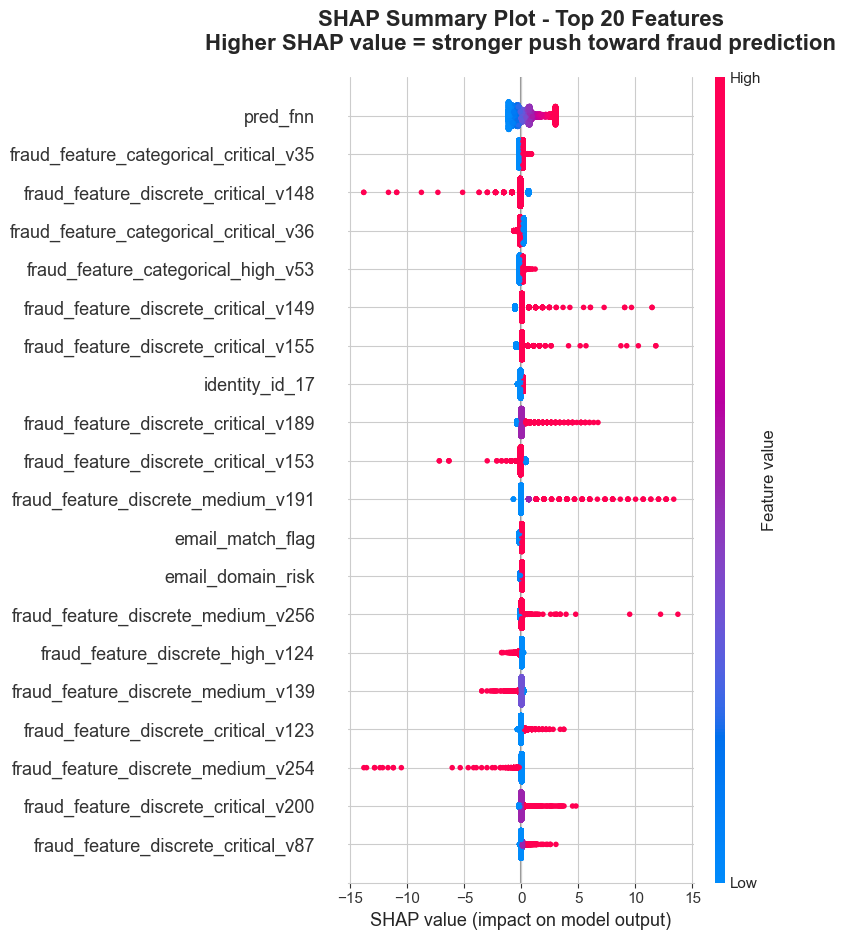

✓ Saved: ..\..\Results\explainability\shap_summary_plot.png


In [18]:
print("Creating SHAP Summary Plot...")
print("-"*80)

plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values, 
    X_test_df,
    max_display=20,
    show=False
)
plt.title('SHAP Summary Plot - Top 20 Features\nHigher SHAP value = stronger push toward fraud prediction', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {output_dir / 'shap_summary_plot.png'}")

## Step 5: Feature Importance Bar Plot

Creating Feature Importance Bar Plot...
--------------------------------------------------------------------------------


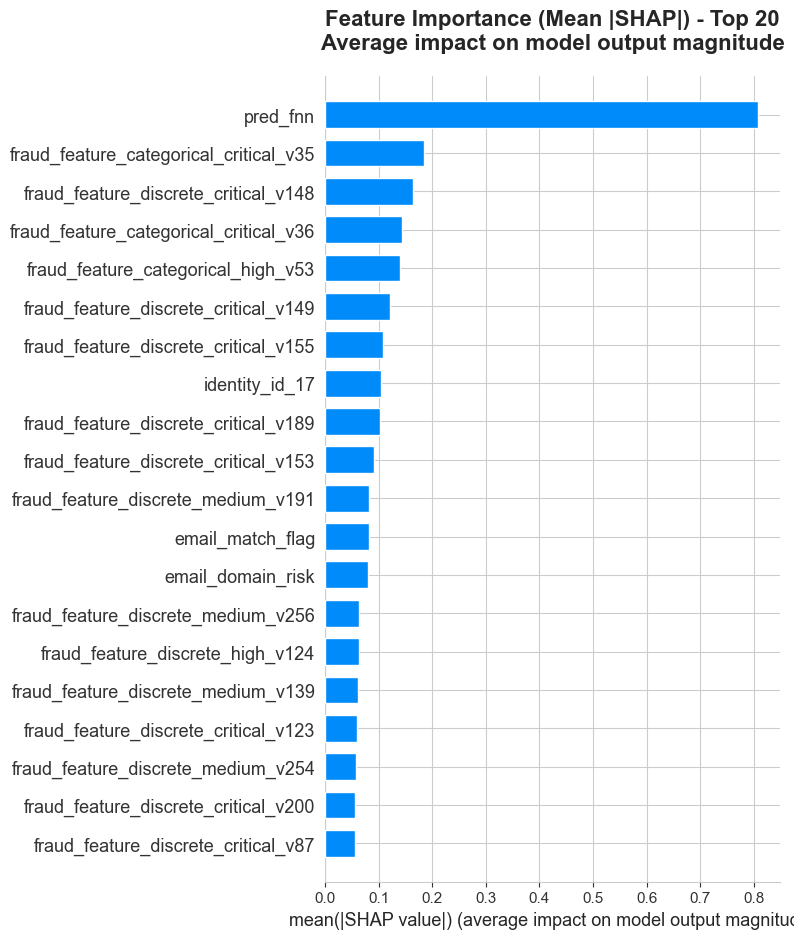

✓ Saved: ..\..\Results\explainability\shap_feature_importance.png


In [19]:
print("Creating Feature Importance Bar Plot...")
print("-"*80)

plt.figure(figsize=(14, 10))
shap.summary_plot(
    shap_values, 
    X_test_df,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title('Feature Importance (Mean |SHAP|) - Top 20\nAverage impact on model output magnitude', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {output_dir / 'shap_feature_importance.png'}")

## Step 6: Extract Top 20 Most Important Features

In [20]:
print("Extracting Top 20 Most Important Features...")
print("-"*80)

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Top 20
top_20_features = feature_importance.head(20)

print("\n" + "="*80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*80)
print(f"{'Rank':<6}{'Feature':<50}{'Importance':<15}")
print("-"*80)
for idx, (_, row) in enumerate(top_20_features.iterrows(), 1):
    print(f"{idx:<6}{row['feature']:<50}{row['importance']:<15.6f}")
print("="*80)

# Save to CSV
top_20_features.to_csv(output_dir / 'top_20_features.csv', index=False)
print(f"\n✓ Saved: {output_dir / 'top_20_features.csv'}")

# Save full feature importance
feature_importance.to_csv(output_dir / 'all_features_importance.csv', index=False)
print(f"✓ Saved: {output_dir / 'all_features_importance.csv'}")

# Display as styled table
top_20_features.style.background_gradient(cmap='YlOrRd', subset=['importance'])

Extracting Top 20 Most Important Features...
--------------------------------------------------------------------------------

TOP 20 MOST IMPORTANT FEATURES
Rank  Feature                                           Importance     
--------------------------------------------------------------------------------
1     pred_fnn                                          0.808383       
2     fraud_feature_categorical_critical_v35            0.185179       
3     fraud_feature_discrete_critical_v148              0.164015       
4     fraud_feature_categorical_critical_v36            0.143779       
5     fraud_feature_categorical_high_v53                0.139624       
6     fraud_feature_discrete_critical_v149              0.120397       
7     fraud_feature_discrete_critical_v155              0.108337       
8     identity_id_17                                    0.103742       
9     fraud_feature_discrete_critical_v189              0.103187       
10    fraud_feature_discrete_critical_v15

,feature,importance
97,pred_fnn,0.808383
13,fraud_feature_categorical_critical_v35,0.185179
47,fraud_feature_discrete_critical_v148,0.164015
14,fraud_feature_categorical_critical_v36,0.143779
19,fraud_feature_categorical_high_v53,0.139624
48,fraud_feature_discrete_critical_v149,0.120397
51,fraud_feature_discrete_critical_v155,0.108337
89,identity_id_17,0.103742
56,fraud_feature_discrete_critical_v189,0.103187
49,fraud_feature_discrete_critical_v153,0.091771


In [27]:
print("Generating predictions for sample analysis...")
print("-"*80)

# SOLUTION: Use numpy arrays for predictions (no column name checking)
# The feature ORDER is correct, only the NAMES are different

# Convert to numpy array (bypasses sklearn's feature name validation)
X_test_values = X_test_df.values

# Make predictions using numpy array
y_pred = meta_learner.predict(X_test_values)
y_pred_proba = meta_learner.predict_proba(X_test_values)[:, 1]

print(f"✓ Generated predictions for {len(y_pred):,} samples")
print(f"  Predicted frauds: {y_pred.sum():,}")
print(f"  Predicted legitimate: {(y_pred == 0).sum():,}")
print(f"\n✓ Feature order preserved - predictions are valid")
print(f"✓ SHAP visualizations will display renamed feature names")

Generating predictions for sample analysis...
--------------------------------------------------------------------------------
✓ Generated predictions for 12,064 samples
  Predicted frauds: 2,555
  Predicted legitimate: 9,509

✓ Feature order preserved - predictions are valid
✓ SHAP visualizations will display renamed feature names


## Step 6.1: Generate Predictions for Sample Analysis

## Step 7: Waterfall Plots for Individual Predictions

In [29]:
print("Creating Waterfall Plots for Sample Predictions...")
print("-"*80)

# Use predictions from previous cell (y_pred and y_pred_proba already generated)

# Select samples: true frauds, false positives, true negatives
true_frauds = np.where((y_test_new == 1) & (y_pred == 1))[0]
false_positives = np.where((y_test_new == 0) & (y_pred == 1))[0]
true_negatives = np.where((y_test_new == 0) & (y_pred == 0))[0]

# Create a sample set with diverse predictions
sample_indices = {
    'True Fraud (High Confidence)': true_frauds[np.argmax(y_pred_proba[true_frauds])] if len(true_frauds) > 0 else None,
    'True Fraud (Low Confidence)': true_frauds[np.argmin(y_pred_proba[true_frauds])] if len(true_frauds) > 0 else None,
    'False Positive (High Confidence)': false_positives[np.argmax(y_pred_proba[false_positives])] if len(false_positives) > 0 else None,
    'False Positive (Low Confidence)': false_positives[np.argmin(y_pred_proba[false_positives])] if len(false_positives) > 0 else None,
    'True Negative (High Confidence)': true_negatives[np.argmin(y_pred_proba[true_negatives])] if len(true_negatives) > 0 else None,
    'True Negative (Low Confidence)': true_negatives[np.argmax(y_pred_proba[true_negatives])] if len(true_negatives) > 0 else None,
}

print(f"Selected {sum(1 for v in sample_indices.values() if v is not None)} diverse sample predictions\n")

# Create waterfall plots for each sample
for title, idx in sample_indices.items():
    if idx is None:
        continue
    
    # Get prediction details
    actual = "Fraud" if y_test_new[idx] == 1 else "Legitimate"
    predicted = "Fraud" if y_pred[idx] == 1 else "Legitimate"
    confidence = y_pred_proba[idx] * 100
    
    print(f"{title}:")
    print(f"  Sample index: {idx}")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Fraud probability: {confidence:.2f}%")
    
    # Create waterfall plot
    plt.figure(figsize=(14, 8))
    
    # Get the expected value
    if hasattr(explainer.expected_value, '__iter__'):
        base_val = explainer.expected_value[1]
    else:
        base_val = explainer.expected_value
    
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=base_val,
            data=X_test_df.iloc[idx].values,
            feature_names=feature_names
        ),
        max_display=15,
        show=False
    )
    
    plt.title(f"{title}\\n{actual} → Predicted {predicted} ({confidence:.2f}% fraud probability)", 
              fontsize=14, pad=20)
    plt.tight_layout()
    
    # Save plot
    safe_filename = title.lower().replace(' ', '_').replace('(', '').replace(')', '')
    filename = output_dir / f"waterfall_{safe_filename}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {filename.name}\\n")
    plt.close()

print("✓ All waterfall plots created")

Creating Waterfall Plots for Sample Predictions...
--------------------------------------------------------------------------------
Selected 6 diverse sample predictions

True Fraud (High Confidence):
  Sample index: 4780
  Actual: Fraud
  Predicted: Fraud
  Fraud probability: 100.00%
  ✓ Saved: waterfall_true_fraud_high_confidence.png\n
True Fraud (Low Confidence):
  Sample index: 2691
  Actual: Fraud
  Predicted: Fraud
  Fraud probability: 50.06%
  ✓ Saved: waterfall_true_fraud_low_confidence.png\n
False Positive (High Confidence):
  Sample index: 1809
  Actual: Legitimate
  Predicted: Fraud
  Fraud probability: 99.61%
  ✓ Saved: waterfall_false_positive_high_confidence.png\n
False Positive (Low Confidence):
  Sample index: 7293
  Actual: Legitimate
  Predicted: Fraud
  Fraud probability: 50.00%
  ✓ Saved: waterfall_false_positive_low_confidence.png\n
True Negative (High Confidence):
  Sample index: 7157
  Actual: Legitimate
  Predicted: Legitimate
  Fraud probability: 0.00%
  ✓ Save

## Step 8: Dependence Plots for Top 5 Features

Creating Dependence Plots for Top 5 Features...
--------------------------------------------------------------------------------


<Figure size 1200x700 with 0 Axes>

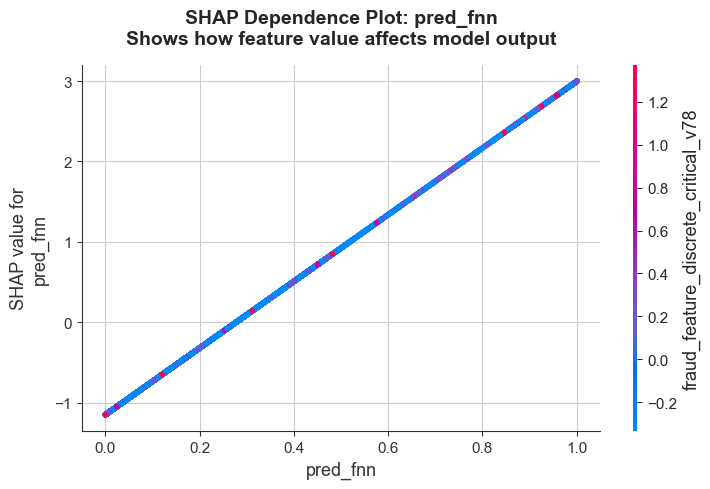

  ✓ Saved: dependence_pred_fnn.png


<Figure size 1200x700 with 0 Axes>

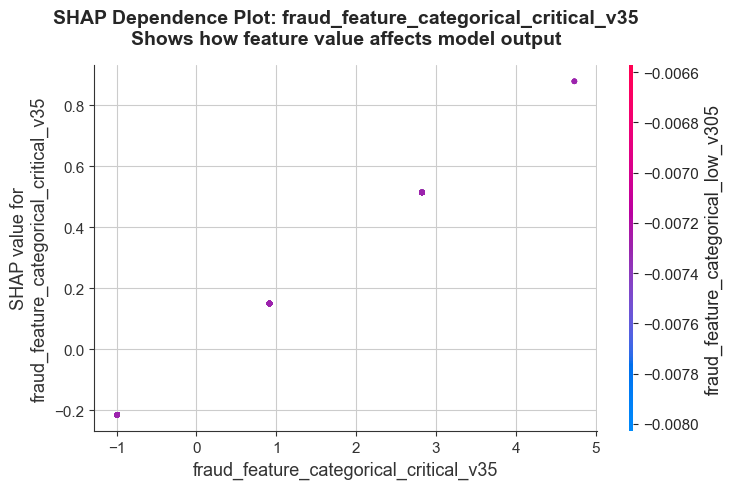

  ✓ Saved: dependence_fraud_feature_categorical_critical_v35.png


<Figure size 1200x700 with 0 Axes>

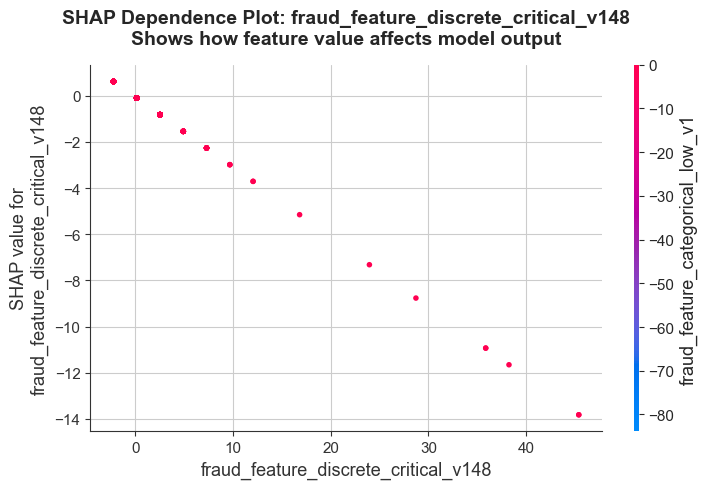

  ✓ Saved: dependence_fraud_feature_discrete_critical_v148.png


<Figure size 1200x700 with 0 Axes>

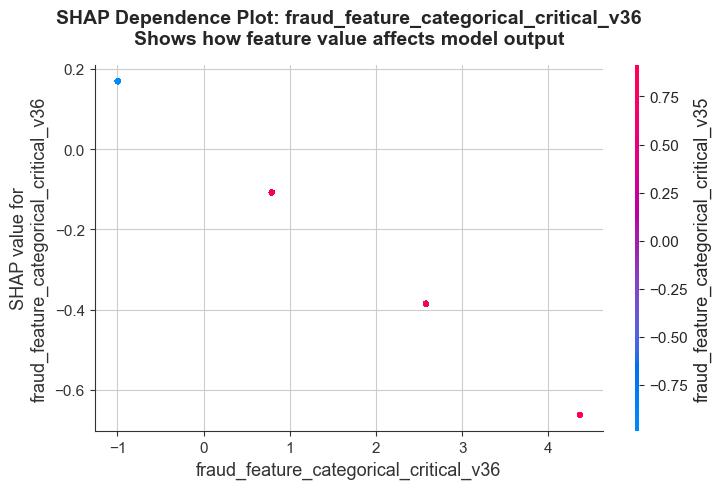

  ✓ Saved: dependence_fraud_feature_categorical_critical_v36.png


<Figure size 1200x700 with 0 Axes>

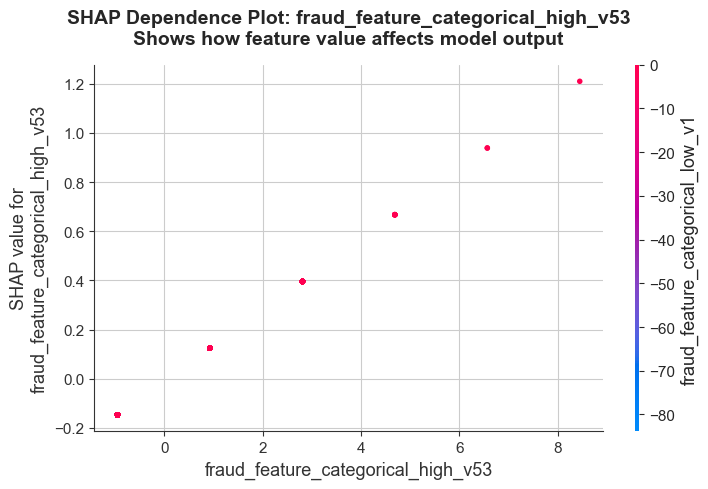

  ✓ Saved: dependence_fraud_feature_categorical_high_v53.png

✓ All dependence plots created


In [22]:
print("Creating Dependence Plots for Top 5 Features...")
print("-"*80)

top_5_features = top_20_features.head(5)

for idx, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_name = row['feature']
    feature_idx = feature_names.index(feature_name)
    
    plt.figure(figsize=(12, 7))
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_test_df,
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {feature_name}\nShows how feature value affects model output', 
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    
    safe_filename = feature_name.replace('/', '_').replace(' ', '_').replace('(', '').replace(')', '')
    plt.savefig(output_dir / f'dependence_{safe_filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved: dependence_{safe_filename}.png")

print(f"\n✓ All dependence plots created")

## Step 9: Force Plots for High-Impact Predictions

Creating Force Plots...
--------------------------------------------------------------------------------

Creating force plot for high-confidence fraud prediction...
  Sample index: 4780
  Fraud probability: 100.00%


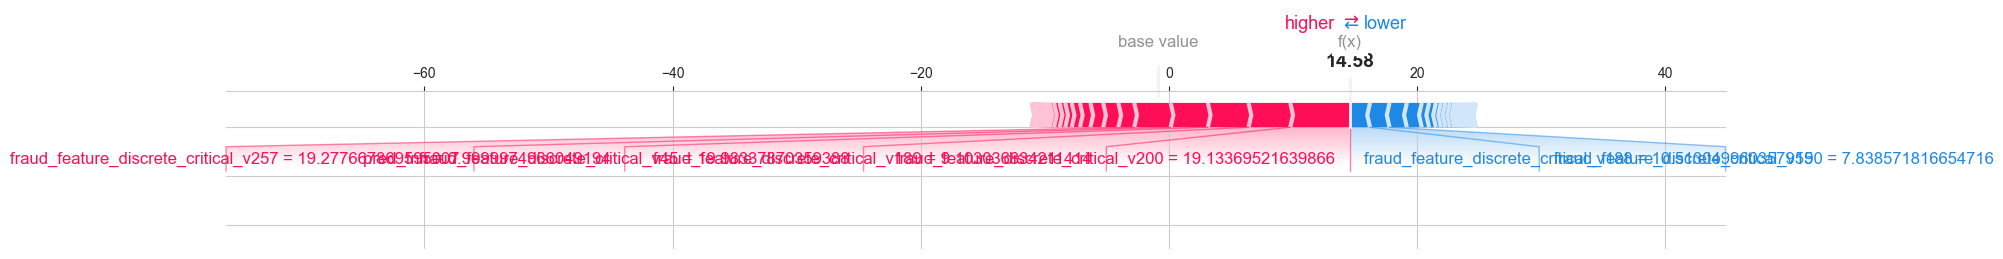

  ✓ Saved: force_plot_fraud.png

Creating force plot for false positive...
  Sample index: 1809
  Fraud probability: 99.61%


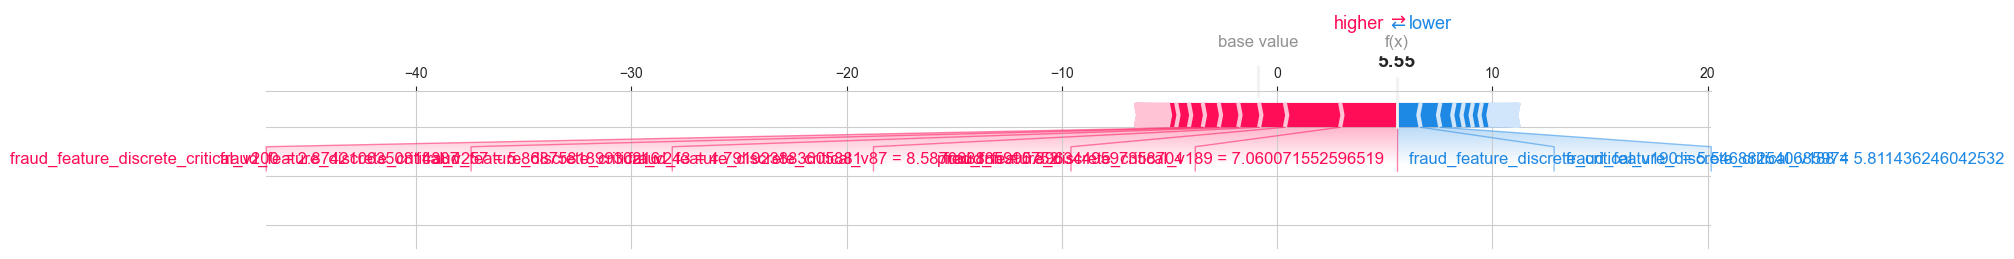

  ✓ Saved: force_plot_false_positive.png

✓ Force plots created


In [23]:
print("Creating Force Plots...")
print("-"*80)

# Get base value
base_val = explainer.expected_value
if isinstance(base_val, np.ndarray):
    base_val = base_val[1]

# Force plot for high-confidence fraud
if len(true_frauds) > 0:
    high_fraud_idx = true_frauds[np.argsort(y_pred_proba[true_frauds])[-1]]
    
    print(f"\nCreating force plot for high-confidence fraud prediction...")
    print(f"  Sample index: {high_fraud_idx}")
    print(f"  Fraud probability: {y_pred_proba[high_fraud_idx]:.2%}")
    
    shap.force_plot(
        base_val,
        shap_values[high_fraud_idx],
        X_test_df.iloc[high_fraud_idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.tight_layout()
    plt.savefig(output_dir / 'force_plot_fraud.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: force_plot_fraud.png")

# Force plot for false positive
if len(false_positives) > 0:
    high_fp_idx = false_positives[np.argsort(y_pred_proba[false_positives])[-1]]
    
    print(f"\nCreating force plot for false positive...")
    print(f"  Sample index: {high_fp_idx}")
    print(f"  Fraud probability: {y_pred_proba[high_fp_idx]:.2%}")
    
    shap.force_plot(
        base_val,
        shap_values[high_fp_idx],
        X_test_df.iloc[high_fp_idx],
        matplotlib=True,
        show=False,
        figsize=(20, 3)
    )
    plt.tight_layout()
    plt.savefig(output_dir / 'force_plot_false_positive.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: force_plot_false_positive.png")

print(f"\n✓ Force plots created")

## Step 10: Generate Summary Report

In [24]:
print("Generating Summary Report...")
print("-"*80)

summary_report = {
    'model': 'Hybrid Fusion (Feature-based Meta-Learner)',
    'total_features': len(feature_names),
    'test_samples': int(len(X_test_df)),
    'base_value': float(base_val),
    'top_20_features': [
        {
            'rank': idx + 1,
            'feature': row['feature'],
            'importance': float(row['importance'])
        }
        for idx, (_, row) in enumerate(top_20_features.iterrows())
    ],
    'model_performance': {
        'test_f1': model_info['features_api']['test_f1'],
        'test_roc_auc': model_info['features_api']['test_roc_auc'],
        'threshold': model_info['features_api']['threshold']
    },
    'shap_analysis': {
        'total_shap_values_calculated': int(shap_values.shape[0]),
        'features_analyzed': int(shap_values.shape[1]),
        'base_model_predictions': len([f for f in feature_names if f.startswith('pred_')]),
        'raw_features': len([f for f in feature_names if not f.startswith('pred_')])
    },
    'generated_at': '2025-10-09',
    'visualizations_created': [
        'shap_summary_plot.png',
        'shap_feature_importance.png',
        'waterfall plots (6)',
        'dependence plots (5)',
        'force plots (2)'
    ]
}

with open(output_dir / 'shap_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"✓ Saved: {output_dir / 'shap_analysis_summary.json'}")

# Print summary
print("\n" + "="*80)
print("SHAP ANALYSIS SUMMARY")
print("="*80)
print(f"\nModel: {summary_report['model']}")
print(f"Total Features: {summary_report['total_features']}")
print(f"  - Raw Features: {summary_report['shap_analysis']['raw_features']}")
print(f"  - Base Model Predictions: {summary_report['shap_analysis']['base_model_predictions']}")
print(f"\nTest Samples Analyzed: {summary_report['test_samples']:,}")
print(f"Base Value (Expected): {summary_report['base_value']:.4f}")

print(f"\nModel Performance:")
print(f"  F1-Score: {summary_report['model_performance']['test_f1']:.4f}")
print(f"  ROC-AUC: {summary_report['model_performance']['test_roc_auc']:.4f}")

print(f"\nTop 5 Most Important Features:")
for feat in summary_report['top_20_features'][:5]:
    print(f"  {feat['rank']}. {feat['feature']:<45} {feat['importance']:.6f}")

print(f"\nVisualizations Created:")
for viz in summary_report['visualizations_created']:
    print(f"  ✓ {viz}")

print(f"\n✓ All files saved to: {output_dir}")
print("="*80)

Generating Summary Report...
--------------------------------------------------------------------------------
✓ Saved: ..\..\Results\explainability\shap_analysis_summary.json

SHAP ANALYSIS SUMMARY

Model: Hybrid Fusion (Feature-based Meta-Learner)
Total Features: 102
  - Raw Features: 92
  - Base Model Predictions: 10

Test Samples Analyzed: 12,064
Base Value (Expected): -0.8924

Model Performance:
  F1-Score: 0.6186
  ROC-AUC: 0.8633

Top 5 Most Important Features:
  1. pred_fnn                                      0.808383
  2. fraud_feature_categorical_critical_v35        0.185179
  3. fraud_feature_discrete_critical_v148          0.164015
  4. fraud_feature_categorical_critical_v36        0.143779
  5. fraud_feature_categorical_high_v53            0.139624

Visualizations Created:
  ✓ shap_summary_plot.png
  ✓ shap_feature_importance.png
  ✓ waterfall plots (6)
  ✓ dependence plots (5)
  ✓ force plots (2)

✓ All files saved to: ..\..\Results\explainability
